In [1]:
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import helper_fcns as hlp
import autoreload
from scipy.stats import norm, wilcoxon
matplotlib.style.use('plt_style.mplstyle')
%matplotlib inline

In [2]:
dataDir = 'data/';
whichFiles = 'toAnalyzeD1.txt';
dataList = open(dataDir + whichFiles, 'r')
dFilesAll = dataList.readlines(-1)
dFilesAll = [x.strip('\n') for x in dFilesAll]
dataList.close()

In [3]:
#dFiles = dFilesAll;
dFiles = dFilesAll[4:] # ignore the first 4 sessions - early training

In [4]:
sfIdx = 0;
conIdx = 1;
dispIdx = 2;
nInd = 3; # 3 indices per stimulus; add 3 to all of the above indices to get the equivalent value for the second stimulus
subjRespIdx = 2*nInd;
refIdx = subjRespIdx + 1; # which interval contained reference is after the subject's response in the data format

In [5]:
stim1 = 39; stim2 = 41; # subject responses (asked which stimulus has higher SF)

In [6]:
data = [];
for df in dFiles:
    currData = np.loadtxt(dataDir + df);
    print('Adding ' + str(currData.shape[0]) + ' trials')
    if df == dFiles[0]:
        data = currData;
    else:
        data = np.concatenate((data, currData), axis = 0);

sfVals = np.union1d(np.unique(data[:, sfIdx]), np.unique(data[:, sfIdx+nInd]))
conVals = np.union1d(np.unique(data[:, conIdx]), np.unique(data[:, conIdx+nInd]))
dispVals = np.union1d(np.unique(data[:, dispIdx]), np.unique(data[:, dispIdx+nInd]))

Adding 150 trials
Adding 150 trials
Adding 150 trials
Adding 150 trials
Adding 150 trials
Adding 150 trials
Adding 150 trials
Adding 150 trials
Adding 150 trials
Adding 150 trials
Adding 150 trials
Adding 150 trials
Adding 150 trials
Adding 150 trials
Adding 150 trials
Adding 150 trials
Adding 150 trials
Adding 150 trials
Adding 150 trials
Adding 150 trials
Adding 150 trials
Adding 150 trials


In [7]:
allResp = data[:, subjRespIdx];
if any((allResp != stim1) & (allResp != stim2)):
    print('Problem: response which is neither 1 or 2')

In [8]:
s1g = data[:, sfIdx] > data[:, sfIdx+nInd];
s2g = data[:, sfIdx] < data[:, sfIdx+nInd]

In [36]:
# find which one is the reference (as opposed to test) grating
ref = np.zeros(data.shape[0])
ref = data[:, refIdx]

# allows for possibility of more than one refSf...
refSF = np.union1d(np.unique(data[ref==1, sfIdx]), np.unique(data[ref==2, sfIdx+nInd]))

In [25]:
# did the subject perceive the test as higher SF?
testHF = np.zeros(data.shape[0]);
testHF[ref==1] = data[ref==1, subjRespIdx] == stim2;
testHF[ref==2] = data[ref==2, subjRespIdx] == stim1;

In [26]:
testCons = np.zeros(data.shape[0])
testCons[ref==1] = data[ref==1, nInd+conIdx];
testCons[ref==2] = data[ref==2, conIdx];

In [29]:
testSfs = np.zeros(data.shape[0])
testSfs[ref==1] = data[ref==1, nInd+sfIdx];
testSfs[ref==2] = data[ref==2, sfIdx];

In [30]:
checkz = np.zeros((len(testSfs), 1));
for i in range(len(sfVals)):
    checkz[testSfs == sfVals[i]] = 1;

In [31]:
# data analysis - number of trials/responses "test>ref sf", fraction "test>ref" split by sf/con
ptSf, nTr, nTestResp = (np.zeros((len(conVals), len(sfVals))) for _ in range(3));
for con in range(len(conVals)):
    for sf in range(len(sfVals)):
        z = (testSfs == sfVals[sf]) & (testCons == conVals[con]) # get trials with the desired test sf/con
        nTr[con][sf] = sum(z); # how many trials in this configuration
        nTestResp[con][sf] = sum(testHF[z]) # how many trials in this configuration with response "test > ref sf"
        ptSf[con][sf] = nTestResp[con][sf] / nTr[con][sf]
    print('Con ' + str(conVals[con]) + ': ' + str(sum(nTr[con])) + ' trials')

Con 0.05: 791.0 trials
Con 0.1: 830.0 trials
Con 0.33: 853.0 trials
Con 1.0: 826.0 trials


In [32]:
# optimize and bootstrap
nFits = 5; # don't think you really need multistart, but good to have flexibility
bootIter = 100; # set to 0 for no bootstrap
nParams = 4;
bootTestResps = np.zeros((len(conVals), len(nTestResp[0]), bootIter))
params = np.zeros((len(conVals), nParams));
loss = np.zeros((len(conVals), 1)); # only one loss value...
paramsBoot = np.zeros((len(conVals), nParams, bootIter));

for c in range(len(conVals)):
    opt = hlp.opt_pmf(sfVals, nTestResp[c], nTr[c], norm.cdf, nFits)
    params[c, :] = opt['x'];
    loss[c] = opt['fun'];
    
    for iter in range(bootIter):
        bootTestResps[c, :, iter] = np.random.binomial(nTr.astype('int64')[c], ptSf[c])
        optBoot = hlp.opt_pmf(sfVals, bootTestResps[c, :, iter], nTr[c], norm.cdf, 1)
        paramsBoot[c, :, iter] = optBoot['x'];

In [33]:
# compute from bootstrap values...
bootParamMean = paramsBoot.mean(-1);
bootParamStd = paramsBoot.std(-1);

# reshape number of trials by con/sf so we can get bootstrap estimates of subject's proportion responses "test>ref"
bootPtSf = bootTestResps / np.repeat(nTr.reshape((len(conVals), len(nTestResp[0]), 1)), 100, axis=-1); 
bootPtSfmean = bootPtSf.mean(-1);
bootPtSfstd = bootPtSf.std(-1);

### Plot of psychometric function and measured responses

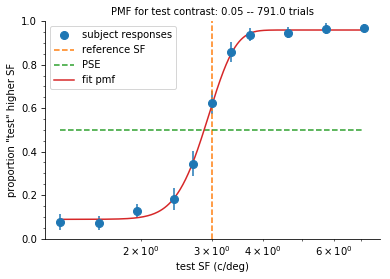

In [60]:
# now plot the PMF
whichCon = 0;
x = np.arange(sfVals[0], sfVals[-1], 1e-2);
true_pmf = lambda params: params[2] + (1-params[2]-params[3])*norm.cdf(x, *params[0:2])

pts = plt.errorbar(sfVals, ptSf[whichCon], yerr=bootPtSfstd[whichCon, :], clip_on=False, linestyle='none', marker='o');
refSFline = plt.semilogx([refSF, refSF], [0, 1], '--'); 
pse = plt.semilogx([sfVals[0], sfVals[-1]], [0.5, 0.5], '--')
pmf = plt.semilogx(x, true_pmf(params[whichCon, :]), '-');
plt.ylim([0, 1]);
plt.xlabel('test SF (c/deg)');
plt.ylabel('proportion "test" higher SF');
plt.legend((pts[0], refSFline[0], pse[0], pmf[0]), ('subject responses', 'reference SF', 'PSE', 'fit pmf'));
plt.title('PMF for test contrast: ' + str(conVals[whichCon]) + ' -- ' + str(sum(nTr[whichCon])) + ' trials');

### Comparison of two contrasts

In [68]:
ptSf[:, 5]

array([ 0.625 ,  0.5618,  0.5165,  0.5055])

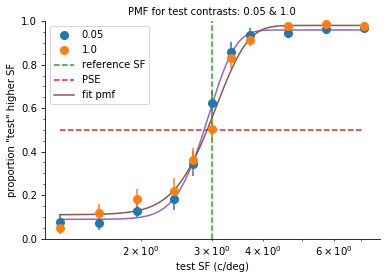

In [63]:
con1 = 0; con2 = 3;
x = np.arange(sfVals[0], sfVals[-1], 1e-2)
true_pmf = lambda params: params[2] + (1-params[2]-params[3])*norm.cdf(x, *params[0:2])

pts = plt.errorbar(sfVals, ptSf[con1], yerr=bootPtSfstd[con1, :], clip_on=False, linestyle='none', marker='o');
pts2 = plt.errorbar(sfVals, ptSf[con2], yerr=bootPtSfstd[con2, :], clip_on=False, linestyle='none', marker='o');
refSFline = plt.semilogx([refSF, refSF], [0, 1], '--'); 
pse = plt.semilogx([sfVals[0], sfVals[-1]], [0.5, 0.5], '--')
pmf = plt.semilogx(x, true_pmf(params[con1, :]), '-');
pmf = plt.semilogx(x, true_pmf(params[con2, :]), '-');
plt.ylim([0, 1]);
plt.xlabel('test SF (c/deg)');
plt.ylabel('proportion "test" higher SF');
plt.legend((pts[0], pts2[0], refSFline[0], pse[0], pmf[0]), (str(conVals[con1]), str(conVals[con2]), 'reference SF', 'PSE', 'fit pmf'));
plt.title('PMF for test contrasts: ' + str(conVals[con1]) + ' & ' + str(conVals[con2]));

### Plot of subject bias and sensitivity

In [77]:
pse = np.zeros((len(conVals), 1));
evalSfs = np.arange(sfVals[0], sfVals[-1], 1e-3);
evalPmf = lambda params: params[2] + (1-params[2]-params[3])*norm.cdf(evalSfs, *params[0:2]);
for con in range(len(conVals)):
    pse[con] = evalSfs[np.argmin(abs(evalPmf(params[con]) - 0.5))]

In [45]:
# Statistics on PSE bootstrapped values...
pOfInt = 0; # PSE
outerInd = len(conVals);
pValPSE = np.nan*np.ones((outerInd, outerInd));
for c in range(outerInd):
    for ci in range(len(conVals) - c-1):
        
        z, pValPSE[c, c+ci+1] = wilcoxon(paramsBoot[c, pOfInt, :], paramsBoot[c+ci+1, pOfInt, :]); # 0 is PSE
        pValPSE[c+ci+1, c] = pValPSE[c, c+ci+1]

In [49]:
print('Significant difference in bootstrap distributions of PSE? P value:')
upTri = np.triu(pValPSE);
np.set_printoptions(precision=4)
np.set_printoptions(suppress=False)
print(upTri)

Significant difference in bootstrap distributions of PSE? P value:
[[         nan   3.2571e-15   1.8508e-14   8.2082e-10]
 [  0.0000e+00          nan   9.0712e-02   9.2928e-04]
 [  0.0000e+00   0.0000e+00          nan   1.2180e-01]
 [  0.0000e+00   0.0000e+00   0.0000e+00          nan]]


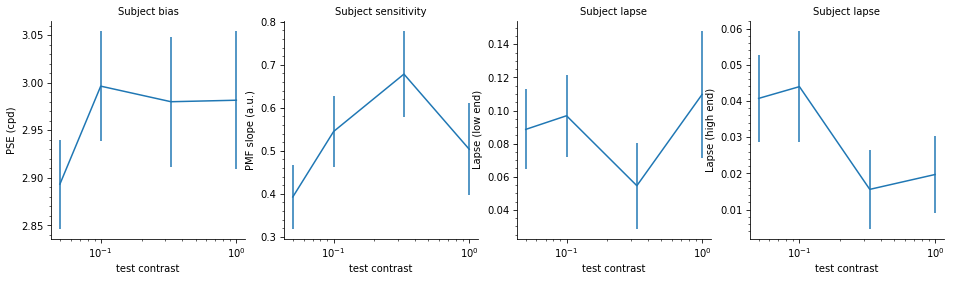

In [70]:
fig, paramPlot = plt.subplots(1, 4, figsize=(16, 4));

paramPlot[0].errorbar(conVals, params[:, 0], bootParamStd[:, 0]);
paramPlot[0].set_xscale('log');
paramPlot[0].set_xlabel('test contrast');
paramPlot[0].set_ylabel('PSE (cpd)');
paramPlot[0].set_title('Subject bias');

paramPlot[1].errorbar(conVals, params[:, 1], bootParamStd[:, 1]);
paramPlot[1].set_xscale('log');
paramPlot[1].set_xlabel('test contrast');
paramPlot[1].set_ylabel('PMF slope (a.u.)');
paramPlot[1].set_title('Subject sensitivity');

paramPlot[2].errorbar(conVals, params[:, 2], bootParamStd[:, 2]);
paramPlot[2].set_xscale('log');
paramPlot[2].set_xlabel('test contrast');
paramPlot[2].set_ylabel('Lapse (low end)');
paramPlot[2].set_title('Subject lapse');

paramPlot[3].errorbar(conVals, params[:, 3], bootParamStd[:, 3]);
paramPlot[3].set_xscale('log');
paramPlot[3].set_xlabel('test contrast');
paramPlot[3].set_ylabel('Lapse (high end)');
paramPlot[3].set_title('Subject lapse');